In [1]:
import numpy as np
import sympy as sp
%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.special import erf
import pickle

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
kappa           = 1e-2      # molecular diffusivity
Bottom          = 0         # bottom of domain
Top             = 0.5         # top of domain
eps             = 1e-1      # "near" wall measure
T               = 1         # final evolution time

nsteps          = int(1e4)
t               = np.linspace(T, 0, nsteps+1)
tau             = t[0] - t
dt              = t[0] - t[1] # t is result of linspace, therefore dt is constant
sqrtdt          = abs(dt)**.5
noiseamplitude  = (2*kappa)**.5

def U(x,t):
    return 0

npoints         = 100   #number of base points
nparticles      = 1000   #number of trajectories at each point
x0              = np.zeros(shape = (npoints, nparticles, 1), dtype = np.float32)
x0[:, :, 0]     = np.linspace(Bottom, Top, npoints)[:, None]
x               = x0.copy()
LT              = np.zeros(shape = (npoints, nparticles, 1), dtype = np.float32)
LB              = LT.copy()
HT              = (T+1)**2*np.ones(shape = (npoints, nparticles, 1), dtype = np.float32)  #(T+1)**2 = "infinity" - will scrap later

In [4]:
for tindex in range(nsteps):
    #print('step {0}'.format(tindex))
    # get velocity
    u = U(x,t[tindex])
    # Euler Maruyama
    dW = np.random.randn(*x.shape)*sqrtdt
    dX = -u*dt + noiseamplitude*dW
    x += dX
    cond1 = x[..., 0] < Bottom + eps
    cond2 = x[..., 0] > Top    - eps
    # Record first hitting time    
    HT[np.logical_or(cond1, cond2)] = np.minimum(HT[np.logical_or(cond1, cond2)], tau[tindex])
    # Lepingle's algorithm
    c1indices = np.where(cond1)    # condition 1: particle wanders near the bottom wall
    if c1indices[0].size > 0:
        V  =  -2*dt*np.log(np.random.random(x.shape))[c1indices]
        Y  = (-dX[c1indices] + np.sqrt(2*kappa*V + dX[c1indices]**2))/2
        dL =  Y - x[c1indices] + Bottom
        dL[np.where(dL < 0)] = 0
        x[c1indices]  += dL
        LB[c1indices] += dL/kappa
    c2indices = np.where(cond2)    # condition 2:  particle wanders near the top wall
    if c2indices[0].size > 0:
        V  =  -2*dt*np.log(np.random.random(x.shape))[c2indices]
        Y  = (-dX[c2indices] + np.sqrt(2*kappa*V + dX[c2indices]**2))/2
        dL =  Y + x[c2indices] - Top
        dL[np.where(dL < 0)] = 0
        x[c2indices]  -= dL
        LT[c2indices] += dL/kappa
    x[..., 0] = np.clip(x[..., 0], Bottom, Top)

KeyboardInterrupt: 

In [2]:
#### Record Paramters ###

#param = np.array((kappa, Bottom, Top, eps, nsteps, dt, npoints, nparticles), dtype=float)

####### Dump Data #######

#pickle.dump(x,     open( "data_pure_brownian/x.p",     "wb" ) )
#pickle.dump(LT,    open( "data_pure_brownian/LT.p",    "wb" ) )
#pickle.dump(LB,    open( "data_pure_brownian/LB.p",    "wb" ) )
#pickle.dump(param, open( "data_pure_brownian/param.p", "wb" ) )


####### Load Data #######

x     = pickle.load( open( "data_pure_brownian/x.p",     "rb" ) )
LT    = pickle.load( open( "data_pure_brownian/LT.p",    "rb" ) )
LB    = pickle.load( open( "data_pure_brownian/LB.p",    "rb" ) )
HT    = pickle.load( open( "data_pure_brownian/HT.p",    "rb" ) )
param = pickle.load( open( "data_pure_brownian/param.p", "rb" ) )


#### Set Parameters #####
kappa       = param[0]
Bottom      = param[1]
Top         = param[2]
eps         = param[3]
nsteps      = param[4]
dt          = param[5]
T           = nsteps*dt
npoints     = param[6]
nparticles  = param[7]
x0[:, :, 0] = np.linspace(Bottom, Top, npoints)[:, None]

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [65]:
####### Compute Expected Local Times and Variances #######

ELT   = np.average(LT,    axis = 1)
ELB   = np.average(LB,    axis = 1)
VarLT = np.average(LT**2, axis = 1) - ELT**2
VarLB = np.average(LB**2, axis = 1) - ELB**2
CovL  = np.average(LB*LT, axis = 1) - ELT*ELB

<IPython.core.display.Javascript object>


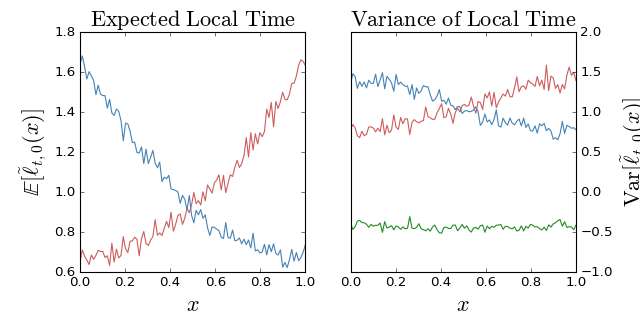

In [66]:
######## Plot Expected Local Times and Variances ########

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)
plt.gcf().subplots_adjust(bottom=0.15)

ax1.plot(x0[:, 0, 0], ELT, color = 'Indianred')
ax1.plot(x0[:, 0, 0], ELB, color = 'Steelblue')

ax1.set_xlim([Bottom,Top])
ax1.set_title('$\\rm Expected\ Local\ Time$', fontsize=20)
ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$\\mathbb{E}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)

ax2.plot(x0[:, 0, 0], VarLT, color = 'Indianred')
ax2.plot(x0[:, 0, 0], VarLB, color = 'Steelblue')
ax2.plot(x0[:, 0, 0], CovL,    color = 'Forestgreen')

ax2.set_xlim([Bottom,Top])
ax2.set_title('$\\rm Variance\ of\ Local\ Time$', fontsize=20)
ax2.set_xlabel('$x$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('${\\rm Var}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)

<IPython.core.display.Javascript object>


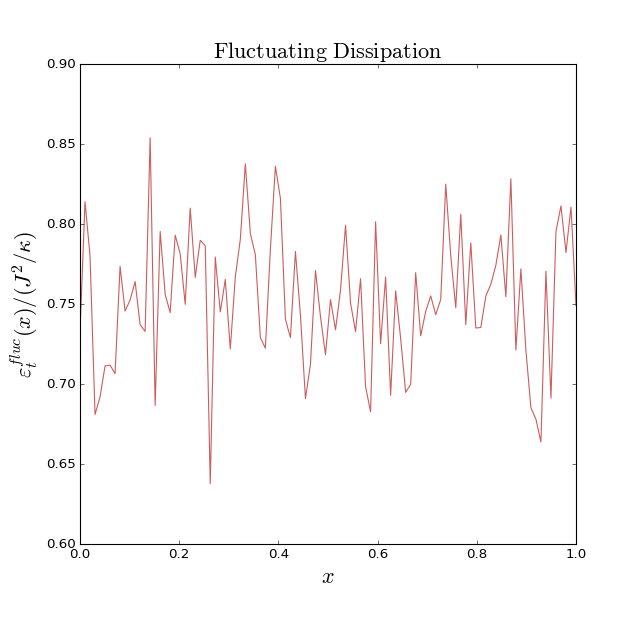

In [67]:
####### Plot Fluctuating Dissipation #######

J=1
FluctuatingDissipation = (0.5/T)*(VarLT + VarLB - 2*CovL)
FluctuatingDissipation = FluctuatingDissipation/(J**2/kappa)

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)

plt.gcf().subplots_adjust(bottom=0.15)
ax.plot(x0[:, 0, 0], FluctuatingDissipation, color = 'Indianred')

ax.set_xlim([Bottom,Top])
ax.set_title('$\\rm Fluctuating\ Dissipation$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$\\varepsilon_t^{fluc}(x)/(J^2/\kappa)$', fontsize=20)

In [24]:
print T

5.0


Use Takac's Eq.(3) as a test on the numerics. For a Brownian motion started at $x_0>0$ at time $t$ and reflected at $x=0$, the PDF $p_{x_0,\tau}(\ell)$ of the local time density at $x=0$ is 

$ p_{x_0,\tau}(\ell)=   \Big(\sqrt{\frac{\kappa}{\pi \tau}} e^{-(x_0+2\kappa \ell)^2/4\kappa \tau}\Big) \Theta(\ell) + \Big(2\Phi_{\kappa,\tau}(x_0)-1\Big) \delta(\ell)$

where $\tau=t-s$, $\Theta(\ell)$ is the Heaviside set-function and $\Phi_{\kappa,t}(x)=\frac{1}{\sqrt{4\pi\kappa t}} \int_{-\infty}^{x} dy\  e^{-y^2/4\kappa t}$ (i.e., the CDF of the normal random variable $N(0,2\kappa t)$).  The CDF is:

$ P_{x_0,\tau}(\ell\leq L)= 2\Phi_{\kappa,\tau}(x_0+ 2\kappa L)-1 =  {\rm erf}\big(\frac{ x_0+ 2\kappa L}{\sqrt{4\kappa \tau}}\big)$

where the error function is defined as ${\rm erf}(x) = \frac{1}{\sqrt{2\pi}}\int_{-x}^x dy\  e^{-y^2}$.

In [68]:
def CDFofNormal(x,t):
    return 0.5*(1 + erf(x/np.sqrt(4*kappa*t)))

def localTimeCDF(L,x0,t):
    return  2*CDFofNormal(x0 + 2*kappa*L, t)-1 

def localTimePDF(ell,x0,t):
    return np.sqrt(kappa/np.pi*t)*np.exp(-(x0 + 2*kappa*ell)**2/(4*kappa*t))

def stoppingTimePDF(tau,x0):
    return x0*np.exp(-(x0-Bottom)**2/(4*kappa*tau))/np.sqrt(4*np.pi*kappa*tau**3)

def  TakacsLocalTime(ell,x0,t):
    L = 10
    p = 1 ;
    for l in range(1,L):
        p = p + (-1)**(l-1)(1 - CDFofNormal(x0 + 2*kappa*L, t))
    return p

In [69]:
#print LB[1,:]
#print LB[2,:]
#print LB[3,:]
print np.min(LT[4,:])
print LB.shape

0.0
(100, 1000, 1)


<IPython.core.display.Javascript object>


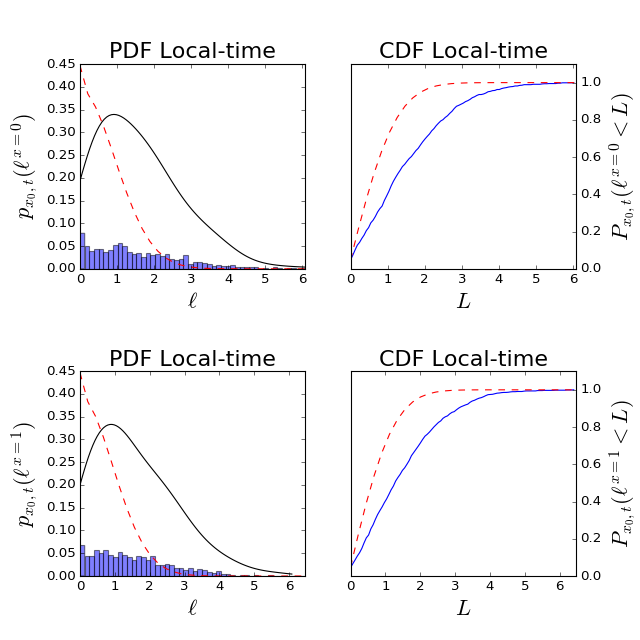

In [70]:
II = 6
space_index   =  II
space_index2  = -II
dataB         = LB[space_index,:]
dataT         = LT[space_index2,:]
MB            = np.max(dataB)
MT            = np.max(dataT)


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################


X_plot = np.linspace(0, MB, 100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(dataB)
log_dens = kde.score_samples(X_plot)
ax3.plot(X_plot, np.exp(log_dens), '-k')


bins = np.linspace(0, MB, 30)
weights = np.ones_like(dataB[:,0])/len(dataB[:,0]) #the heights add up to be one, transforms frequency plot into density
ax1.hist(dataB, weights = weights, bins = 48, alpha=0.5)
#ax1.hist(dataB, normed= 1, bins = bins, alpha=0.5)
delta_contribution = np.zeros(bins.shape)
for i in range(bins.shape[0]/30):
    delta_contribution[i] = localTimeCDF(0, x0[space_index, 0, 0], T)
ax1.plot(bins, localTimePDF(bins, x0[space_index, 0, 0], T) + delta_contribution, 'r--')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=0})$', fontsize=20)


values, base = np.histogram(dataB, bins = 100, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])

ax2.plot(base[:-1], cumulative, c='blue')
ax2.plot(bins, localTimeCDF(bins, x0[space_index, 0, 0], T), 'r--')



ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=0}<L)$', fontsize=20)

####################################
######### TOP LOCAL TIME ###########
####################################




X_plot = np.linspace(0, MT, 100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(dataT)
log_dens = kde.score_samples(X_plot)
ax1.plot(X_plot, np.exp(log_dens), '-k')


bins = np.linspace(0, MT, 30)
weights = np.ones_like(dataT[:,0])/len(dataT[:,0]) #the heights add up to be one, transforms frequency plot into density
ax3.hist(dataT, weights = weights, bins = 48, alpha=0.5)
#ax3.hist(dataT, normed = 1, bins = bins, alpha=0.5)
delta_contribution = np.zeros(bins.shape)
for i in range(bins.shape[0]/30):
    delta_contribution[i] = localTimeCDF(0, x0[space_index, 0, 0], T)
ax3.plot(bins, localTimePDF(bins, x0[space_index, 0, 0], T) + delta_contribution, 'r--')

ax3.set_title('PDF Local-time', fontsize=20)
ax3.set_xlim([0,MT])
ax3.set_xlabel('$\ell$', fontsize=20)
ax3.set_ylabel('$p_{x_0,t}(\\ell^{x=1})$', fontsize=20)


values, base = np.histogram(dataT, bins = 100, normed = 0)
cumulative   = np.cumsum(values)/float(dataT.shape[0])

ax4.plot(base[:-1], cumulative, c='blue')
ax4.plot(bins, localTimeCDF(bins, x0[space_index, 0, 0], T), 'r--')


ax4.set_xlim([0,MT])
ax4.set_ylim([0,1.1])
ax4.set_title('CDF Local-time', fontsize=20)
ax4.set_xlabel('$L$', fontsize=20)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel('$P_{x_0,t}(\\ell^{x=1}<L)$', fontsize=20)

In [140]:
print X_plot.shape

(350, 1)


<IPython.core.display.Javascript object>


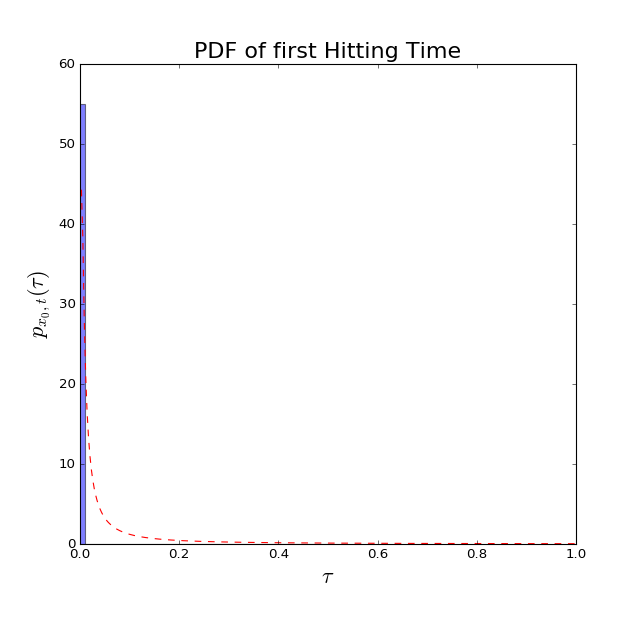

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in divide
/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


In [71]:
space_index = 10

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(bottom=0.15)

data = HT[:, space_index, np.newaxis]
data = data[data < (T+1)**2]


#weights = np.ones_like(data[:])/len(data) 
#this way the heights add up to be one, takes a frequency plot and transforms into a density plot
#ax.hist(data, weights = weights, bins = 28, alpha=0.5)
ax.hist(data, normed = 1, bins = 55, alpha=0.5)
times = np.linspace(0, T, 350)
ax.plot(times, stoppingTimePDF(times, x0[space_index, 0, 0]), 'r--')
ax.set_title('PDF of first Hitting Time', fontsize=20)
ax.set_xlim([0,T])
ax.set_xlabel('$\\tau$', fontsize=20)
ax.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)